# Load Pretrained Models & Dataset

In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch
import os
import numpy as np
import random
import gin
import types
import PIL
import matplotlib
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from model.Beta_VAE import BetaVAE_B, kl_divergence
from model.utils import load_checkpoint, save_checkpoint

In [2]:
import gin
from data.ground_truth import named_data
with gin.unlock_config():
    gin.bind_parameter("dataset.name", "dsprites_full")
dataset = named_data.get_named_ground_truth_data()

# images = np.array(data["images"])
images = dataset.images
n_samples = len(images)

./dataset_folder/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz



In [3]:
def sample_random_batch(batch_size, indices):
    """ Samples a random batch of images.
    Args:
    batch_size: number of images to sample.

    Returns:
    batch: images shape [batch_size,64,64,3].
    """
    ims = []
    for ind in indices:
        im = images[ind]
        im = np.asarray(im)
        ims.append(im)
    ims = np.stack(ims, axis=0)
    ims = ims / 255.
    ims = ims.astype(np.float32)
    ims = ims.reshape([batch_size, 64, 64, 1])
    return ims

def sample_random_batch_torch(batch_size, indices):
    """ Samples a random batch of images.
    Args:
    batch_size: number of images to sample.

    Returns:
    batch: images shape [batch_size,64,64,3].
    """
    ims = []
    for ind in indices:
        im = images[ind]
        im = np.asarray(im)
        ims.append(im)
    ims = np.stack(ims, axis=0)
    ims = ims / 255. 
    ims = ims.astype(np.float32)
    ims = ims.reshape([batch_size, 64, 64, 1])
    ims = torch.from_numpy(ims).permute(0,3,1,2).float()
    return ims

In [4]:
batch_size = 16
indices = np.random.choice(n_samples, batch_size)

x = sample_random_batch_torch(16, indices)
x = x.permute(0,2,3,1)
x = x.detach().cpu().numpy()

In [7]:
net_group = BetaVAE_B(nc =1,group=True, N = 10)
net = BetaVAE_B(nc =1,group=False, N = 10)

import torch.optim as optimizer
optim = optimizer.Adam(net.parameters(), lr=1e-4,betas=(0.9, 0.999))

net,_,_ =  load_checkpoint(0,net,optim,"../../Group_Results/dsprites/20/model")
net_group,_,_ =  load_checkpoint(0,net_group,optim,"../dSprites/30/model")

net.cuda()
net_group.cuda()

=> loaded checkpoint '../../Group_Results/dsprites/20/model (iter 50000)'
=> no checkpoint found at '../dSprites/30/model'


AttributeError: 'int' object has no attribute 'cuda'

In [27]:
def visual_traversal(net, indices):
    def _representation_torch(x):
        x = Variable(torch.from_numpy(x).float()).cuda()
        x = x.permute(0,3,1,2).contiguous()
        z = net.encoder(x)[:,:net.z_dim]
        return z
    
    images = sample_random_batch(16, indices)
    z_ori = _representation_torch(images)[0].unsqueeze(0)
    samples = []
    gifs =[]
    interpolation = torch.arange(-2, 2, 0.4)
    loc = -1
    for row in range(net.z_dim):
        if loc != -1 and row != loc:
            continue
        z = z_ori.clone()
        for val in interpolation:
            z[:, row] = val
            if net.group:
                real = torch.sin(2*np.pi*z/10)
                imag = torch.cos(2*np.pi*z/10)
                cm_z = torch.cat([real,imag],dim=1)
                sample = F.sigmoid(net.decoder(cm_z)).data
            else:
                sample = F.sigmoid(net.decoder(z)).data
            samples.append(sample)
            gifs.append(sample)
    samples = torch.cat(samples, dim=0).cpu()
    return make_grid(samples,nrow=net.z_dim)

# Qualitative comparison of Original/Groupified $\beta$-VAEs
Note that the hyperparamters of these two examples are not the best, but the relative improvement is significant.

In [28]:
indices = np.array([466861])
parallel_number = 1
fix_input = sample_random_batch(parallel_number, indices)
fix_input = fix_input.transpose(1,0, 2, 3).reshape(64, 64*parallel_number, 1)

## Traversal results of Original $\beta$-VAE

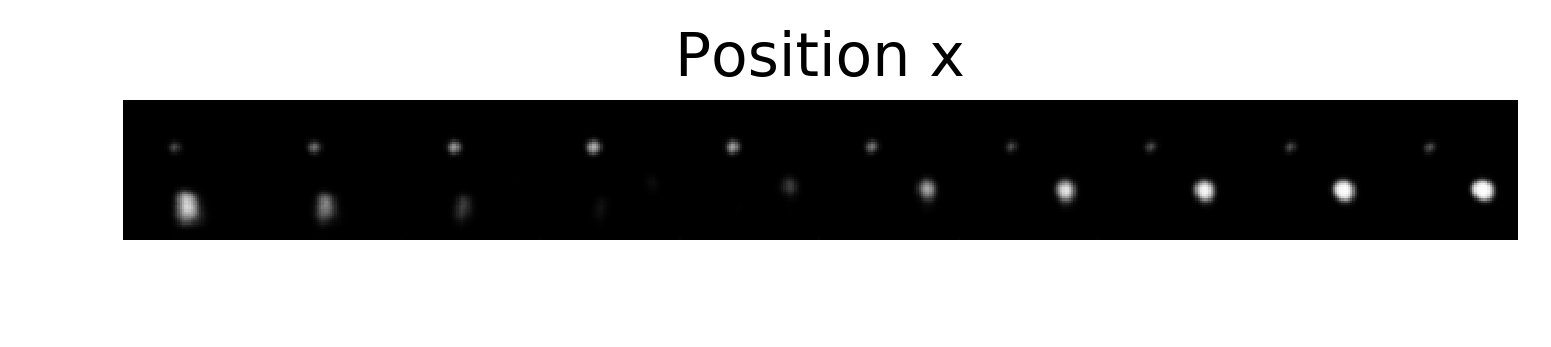

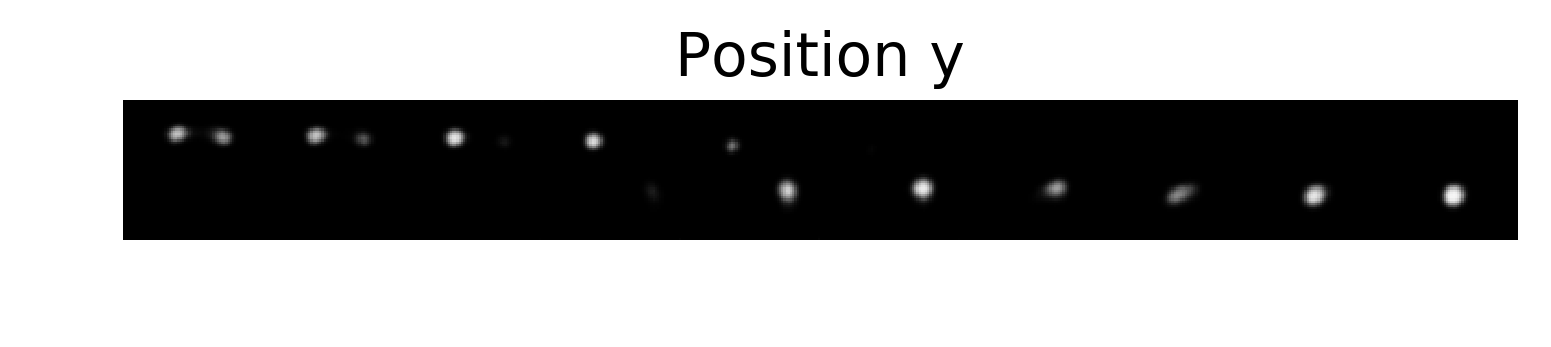

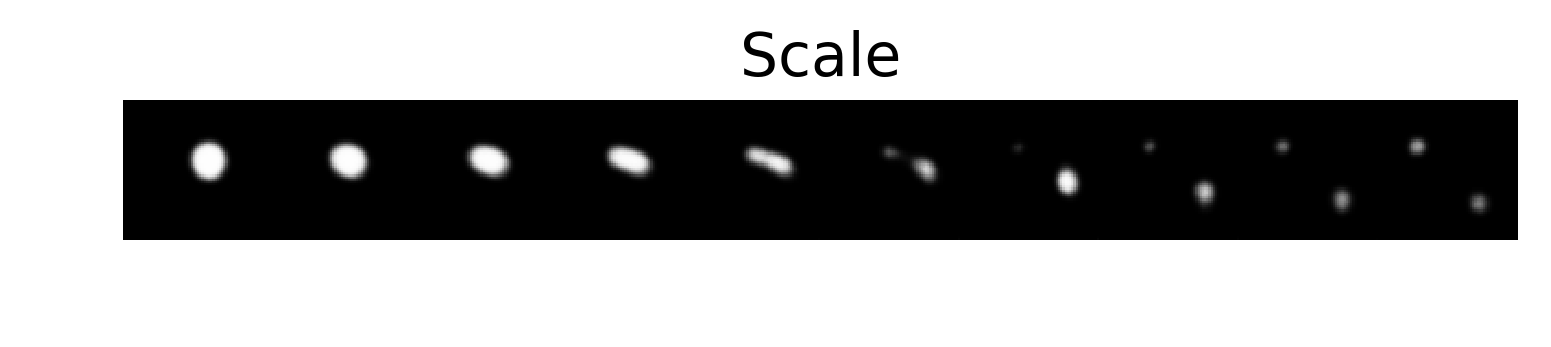

In [29]:
plt.rcParams['figure.dpi'] = 300

target_model = net

specific_line_number = 4

def _representation_torch(x):
    x = Variable(torch.from_numpy(x).float()).cuda()
    x = x.permute(0,3,1,2)
    z = target_model.encoder(x)[:,:target_model.z_dim]
    return z

with torch.no_grad():
    fix_input = sample_random_batch(parallel_number, indices)
    z_ori = _representation_torch(fix_input)
    
    samples = []
    
    interpolation = torch.arange(-2, 2, 0.4)
    # interpolation = torch.arange(-1, 1, 0.4)
    for val in interpolation:
        z = z_ori.clone()
        z[:, specific_line_number] = val
        
        if target_model.group:
            real = torch.sin(2*np.pi*z/10)
            imag = torch.cos(2*np.pi*z/10)
            cm_z = torch.cat([real,imag],dim=1)
            sample = F.sigmoid(target_model.decoder(cm_z)).data
        else:
            sample = F.sigmoid(target_model.decoder(z)).data
                
        samples.append(sample)

    samples = torch.stack(samples)
    samples = samples.permute(1,0,2,3,4).reshape(-1,1,64,64)
    output = make_grid(samples, nrow= 10, padding = 0)
    out_1 = output.detach().cpu().permute(1,2,0).numpy()
    plt.title("Position x")
    plt.imshow(out_1)
    plt.axis('off')
    plt.show()
    
specific_line_number = 0

def _representation_torch(x):
    x = Variable(torch.from_numpy(x).float()).cuda()
    x = x.permute(0,3,1,2)
    z = target_model.encoder(x)[:,:target_model.z_dim]
    return z

with torch.no_grad():
    fix_input = sample_random_batch(parallel_number, indices)
    z_ori = _representation_torch(fix_input)
    
    samples = []
    
    interpolation = torch.arange(-2, 2, 0.4)
    # interpolation = torch.arange(-1, 1, 0.4)
    for val in interpolation:
        z = z_ori.clone()
        z[:, specific_line_number] = val
        
        if target_model.group:
            real = torch.sin(2*np.pi*z/10)
            imag = torch.cos(2*np.pi*z/10)
            cm_z = torch.cat([real,imag],dim=1)
            sample = F.sigmoid(target_model.decoder(cm_z)).data
        else:
            sample = F.sigmoid(target_model.decoder(z)).data
                
        samples.append(sample)

    samples = torch.stack(samples)
    samples = samples.permute(1,0,2,3,4).reshape(-1,1,64,64)
    output = make_grid(samples, nrow= 10, padding = 0)
    out_2 = output.detach().cpu().permute(1,2,0).numpy()
    plt.title("Position y")
    plt.imshow(out_2)
    plt.axis('off')
    plt.show()
    
specific_line_number = 5

def _representation_torch(x):
    x = Variable(torch.from_numpy(x).float()).cuda()
    x = x.permute(0,3,1,2)
    z = target_model.encoder(x)[:,:target_model.z_dim]
    return z

with torch.no_grad():
    fix_input = sample_random_batch(parallel_number, indices)
    z_ori = _representation_torch(fix_input)
    
    samples = []
    
    interpolation = torch.arange(-2, 2, 0.4)
    # interpolation = torch.arange(-1, 1, 0.4)
    for val in interpolation:
        z = z_ori.clone()
        z[:, specific_line_number] = val
        
        if target_model.group:
            real = torch.sin(2*np.pi*z/10)
            imag = torch.cos(2*np.pi*z/10)
            cm_z = torch.cat([real,imag],dim=1)
            sample = F.sigmoid(target_model.decoder(cm_z)).data
        else:
            sample = F.sigmoid(target_model.decoder(z)).data
                
        samples.append(sample)

    samples = torch.stack(samples)
    samples = samples.permute(1,0,2,3,4).reshape(-1,1,64,64)
    output = make_grid(samples, nrow= 10, padding = 0)
    out_3 = output.detach().cpu().permute(1,2,0).numpy()
    plt.title("Scale")
    plt.imshow(out_3)
    plt.axis('off')
    plt.show()

## Traversal results of Groupified $\beta$-VAE

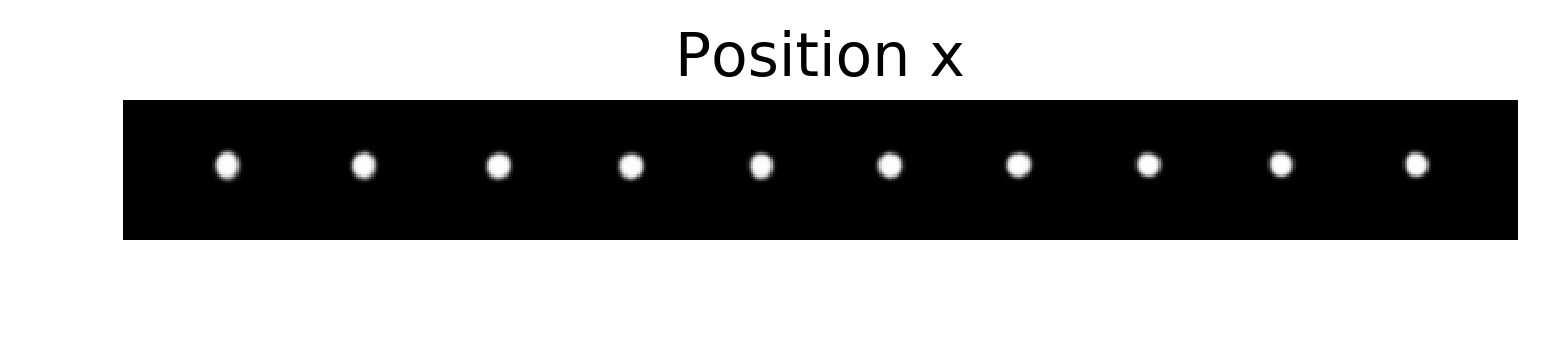

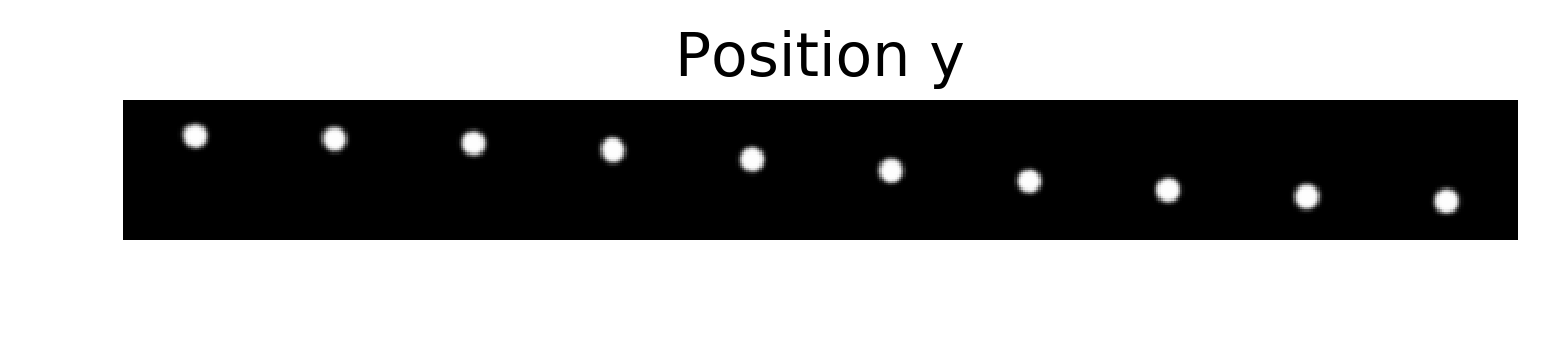

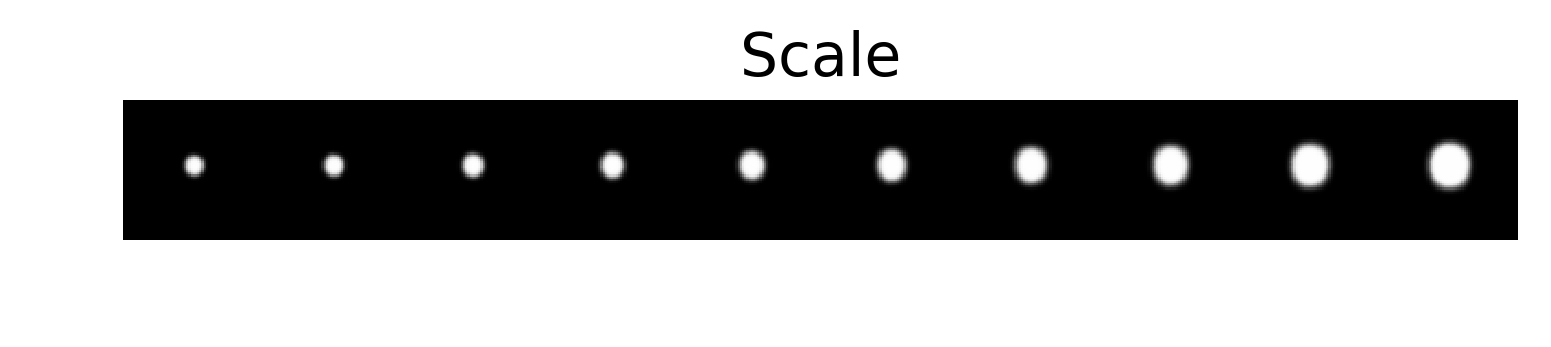

In [30]:
plt.rcParams['figure.dpi'] = 300

target_model = net_group

specific_line_number = 5

def _representation_torch(x):
    x = Variable(torch.from_numpy(x).float()).cuda()
    x = x.permute(0,3,1,2)
    z = target_model.encoder(x)[:,:target_model.z_dim]
    return z

with torch.no_grad():
    fix_input = sample_random_batch(parallel_number, indices)
    z_ori = _representation_torch(fix_input)
    
    samples = []
    
    interpolation = torch.arange(-2, 2, 0.4)
    # interpolation = torch.arange(-1, 1, 0.4)
    for val in interpolation:
        z = z_ori.clone()
        z[:, specific_line_number] = val
        
        if target_model.group:
            real = torch.sin(2*np.pi*z/10)
            imag = torch.cos(2*np.pi*z/10)
            cm_z = torch.cat([real,imag],dim=1)
            sample = F.sigmoid(target_model.decoder(cm_z)).data
        else:
            sample = F.sigmoid(target_model.decoder(z)).data
                
        samples.append(sample)

    samples = torch.stack(samples)
    samples = samples.permute(1,0,2,3,4).reshape(-1,1,64,64)
    output = make_grid(samples, nrow= 10, padding = 0)
    out_1 = output.detach().cpu().permute(1,2,0).numpy()
    plt.title("Position x")
    plt.imshow(out_1)
    plt.axis('off')
    plt.show()
    
specific_line_number = 6

def _representation_torch(x):
    x = Variable(torch.from_numpy(x).float()).cuda()
    x = x.permute(0,3,1,2)
    z = target_model.encoder(x)[:,:target_model.z_dim]
    return z

with torch.no_grad():
    fix_input = sample_random_batch(parallel_number, indices)
    z_ori = _representation_torch(fix_input)
    
    samples = []
    
    interpolation = torch.arange(-2, 2, 0.4)
    # interpolation = torch.arange(-1, 1, 0.4)
    for val in interpolation:
        z = z_ori.clone()
        z[:, specific_line_number] = val
        
        if target_model.group:
            real = torch.sin(2*np.pi*z/10)
            imag = torch.cos(2*np.pi*z/10)
            cm_z = torch.cat([real,imag],dim=1)
            sample = F.sigmoid(target_model.decoder(cm_z)).data
        else:
            sample = F.sigmoid(target_model.decoder(z)).data
                
        samples.append(sample)

    samples = torch.stack(samples)
    samples = samples.permute(1,0,2,3,4).reshape(-1,1,64,64)
    output = make_grid(samples, nrow= 10, padding = 0)
    out_2 = output.detach().cpu().permute(1,2,0).numpy()
    plt.title("Position y")
    plt.imshow(out_2)
    plt.axis('off')
    plt.show()
    
specific_line_number = 9

def _representation_torch(x):
    x = Variable(torch.from_numpy(x).float()).cuda()
    x = x.permute(0,3,1,2)
    z = target_model.encoder(x)[:,:target_model.z_dim]
    return z

with torch.no_grad():
    fix_input = sample_random_batch(parallel_number, indices)
    z_ori = _representation_torch(fix_input)
    
    samples = []
    
    interpolation = torch.arange(-2, 2, 0.4)
    # interpolation = torch.arange(-1, 1, 0.4)
    for val in interpolation:
        z = z_ori.clone()
        z[:, specific_line_number] = val
        
        if target_model.group:
            real = torch.sin(2*np.pi*z/10)
            imag = torch.cos(2*np.pi*z/10)
            cm_z = torch.cat([real,imag],dim=1)
            sample = F.sigmoid(target_model.decoder(cm_z)).data
        else:
            sample = F.sigmoid(target_model.decoder(z)).data
                
        samples.append(sample)

    samples = torch.stack(samples)
    samples = samples.permute(1,0,2,3,4).reshape(-1,1,64,64)
    output = make_grid(samples, nrow= 10, padding = 0)
    out_3 = output.detach().cpu().permute(1,2,0).numpy()
    plt.title("Scale")
    plt.imshow(out_3)
    plt.axis('off')
    plt.show()

# Cyclic representation space of Groupified $\beta$-VAEs

In [31]:
indices = np.array([466861])
parallel_number = 1
fix_input = sample_random_batch(parallel_number, indices)
fix_input = fix_input.transpose(1,0, 2, 3).reshape(64, 64*parallel_number, 1)

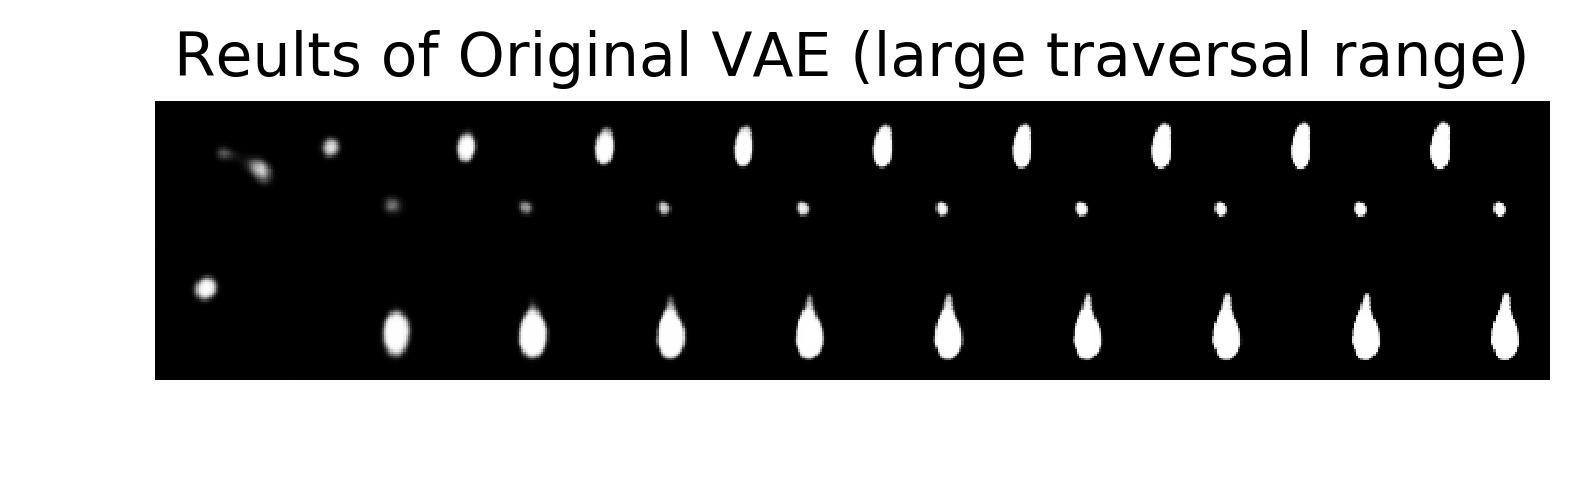

In [32]:
target_model = net
def _representation_torch(x):
    x = Variable(torch.from_numpy(x).float()).cuda()
    x = x.permute(0,3,1,2)
    z = target_model.encoder(x)[:,:target_model.z_dim]
    return z
specific_line_number = 5
with torch.no_grad():
    fix_input = sample_random_batch(parallel_number, indices)
    z_ori = _representation_torch(fix_input)
    
    samples = []
    
    interpolation = torch.arange(0, 20, 2)
    for val in interpolation:
        z = z_ori.clone()
        z[:, specific_line_number] = val
        
        if target_model.group:
            real = torch.sin(2*np.pi*z/10)
            imag = torch.cos(2*np.pi*z/10)
            cm_z = torch.cat([real,imag],dim=1)
            sample = F.sigmoid(target_model.decoder(cm_z)).data
        else:
            sample = F.sigmoid(target_model.decoder(z)).data
                
        samples.append(sample)

specific_line_number = 7
with torch.no_grad():
    fix_input = sample_random_batch(parallel_number, indices)
    z_ori = _representation_torch(fix_input)
    

    interpolation = torch.arange(0, 20, 2)
    for val in interpolation:
        z = z_ori.clone()
        z[:, specific_line_number] = val
        
        if target_model.group:
            real = torch.sin(2*np.pi*z/10)
            imag = torch.cos(2*np.pi*z/10)
            cm_z = torch.cat([real,imag],dim=1)
            sample = F.sigmoid(target_model.decoder(cm_z)).data
        else:
            sample = F.sigmoid(target_model.decoder(z)).data
                
        samples.append(sample)

    samples = torch.stack(samples)
    samples = samples.permute(1,0,2,3,4).reshape(-1,1,64,64)
    output = make_grid(samples, nrow= 10, padding = 0)
    out_5 = output.detach().cpu().permute(1,2,0).numpy()
    plt.title("Reults of Original VAE (large traversal range)")
    plt.imshow(out_5)
    plt.axis('off')
    plt.show()

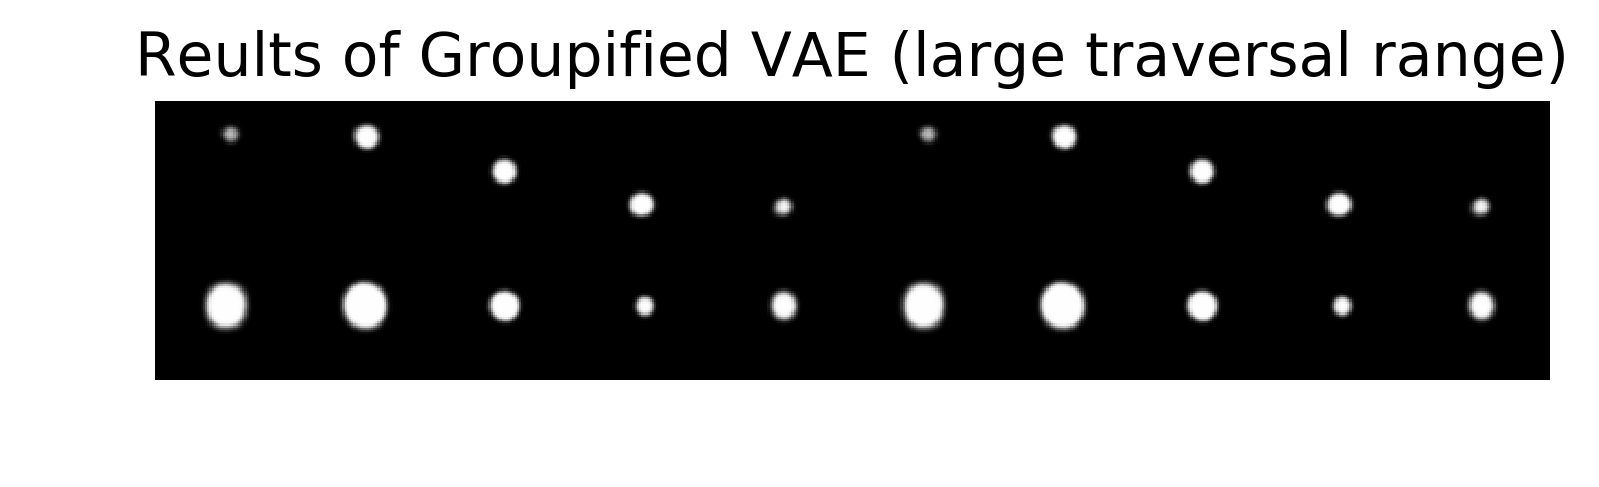

In [33]:
target_model = net_group
def _representation_torch(x):
    x = Variable(torch.from_numpy(x).float()).cuda()
    x = x.permute(0,3,1,2)
    z = target_model.encoder(x)[:,:target_model.z_dim]
    return z
specific_line_number = 6
with torch.no_grad():
    fix_input = sample_random_batch(parallel_number, indices)
    z_ori = _representation_torch(fix_input)
    
    samples = []
    
    interpolation = torch.arange(6, 26, 2)
    for val in interpolation:
        z = z_ori.clone()
        z[:, specific_line_number] = val
        
        if target_model.group:
            real = torch.sin(2*np.pi*z/10)
            imag = torch.cos(2*np.pi*z/10)
            cm_z = torch.cat([real,imag],dim=1)
            sample = F.sigmoid(target_model.decoder(cm_z)).data
        else:
            sample = F.sigmoid(target_model.decoder(z)).data
                
        samples.append(sample)

specific_line_number = 9
with torch.no_grad():
    fix_input = sample_random_batch(parallel_number, indices)
    z_ori = _representation_torch(fix_input)
    

    interpolation = torch.arange(1.5, 21.5, 2)
    for val in interpolation:
        z = z_ori.clone()
        z[:, specific_line_number] = val
        
        if target_model.group:
            real = torch.sin(2*np.pi*z/10)
            imag = torch.cos(2*np.pi*z/10)
            cm_z = torch.cat([real,imag],dim=1)
            sample = F.sigmoid(target_model.decoder(cm_z)).data
        else:
            sample = F.sigmoid(target_model.decoder(z)).data
                
        samples.append(sample)

    samples = torch.stack(samples)
    samples = samples.permute(1,0,2,3,4).reshape(-1,1,64,64)
    output = make_grid(samples, nrow= 10, padding = 0)
    out_5 = output.detach().cpu().permute(1,2,0).numpy()
    plt.title("Reults of Groupified VAE (large traversal range)")
    plt.imshow(out_5)
    plt.axis('off')
    plt.show()

# Representation Space Visualizations

In [34]:
def get_latent_matrix():
    com_matrix = np.zeros((3,6*32*32))
    for k in range(6):
        for i in range(32):
            for j in range(32):
                com_matrix[0,k*32*32+i*32 + j] = k
                com_matrix[1,k*32*32+i*32 + j] = i
                com_matrix[2,k*32*32+i*32 + j] = j

    shape = 0
    orien = 0
    latent_matrix = np.array([[0]*32*32*6,
            [shape]*32*32*6,
            com_matrix[0,:],
            [orien]*32*32*6,
            com_matrix[1,:],
            com_matrix[2,:]])

    latent_matrix = latent_matrix.T
    return latent_matrix
def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_aspect('equal')
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    ax.set_xlabel('Position x')
    ax.set_ylabel('Position y')
    ax.set_zlabel('Scale')
    ax.set_title('Latent space visualization')
    scalarMap.set_array(cs)
    plt.show()
def get_images_from_latent(dataset,latent_matrix):
    indices = np.array(np.dot(latent_matrix, dataset.factor_bases), dtype=np.int64)
    images = dataset.images[indices].astype(np.float32)
    return images
factor_sizes = [10, 10, 10, 8, 4, 15]
def get_latent_matrix_dim(dim=0):
    com_matrix = np.zeros((1,factor_sizes[dim]))
    for k in range(factor_sizes[dim]):
        com_matrix[0,k] = k
    latent_matrix = np.array([com_matrix[0] if i == dim else [2]*factor_sizes[dim] for i in range(6)])

    latent_matrix = latent_matrix.T
    return latent_matrix
def visualize_xys():
    latent_matrix = get_latent_matrix()
    images = get_images_from_latent(dataset,latent_matrix)
    scatter3d(latent_matrix[:,-1],latent_matrix[:,-2],latent_matrix[:,2],cs=np.linspace(0,0.5,32*32*6))

In [35]:
latent_matrix = get_latent_matrix()
images = get_images_from_latent(dataset,latent_matrix)
x = torch.from_numpy(images).cuda()
x = x.unsqueeze(1)
x_r,mu,logvar = net(x.cuda())
mu = mu.detach().cpu().numpy()

# The representation space of Original $\beta$-VAE

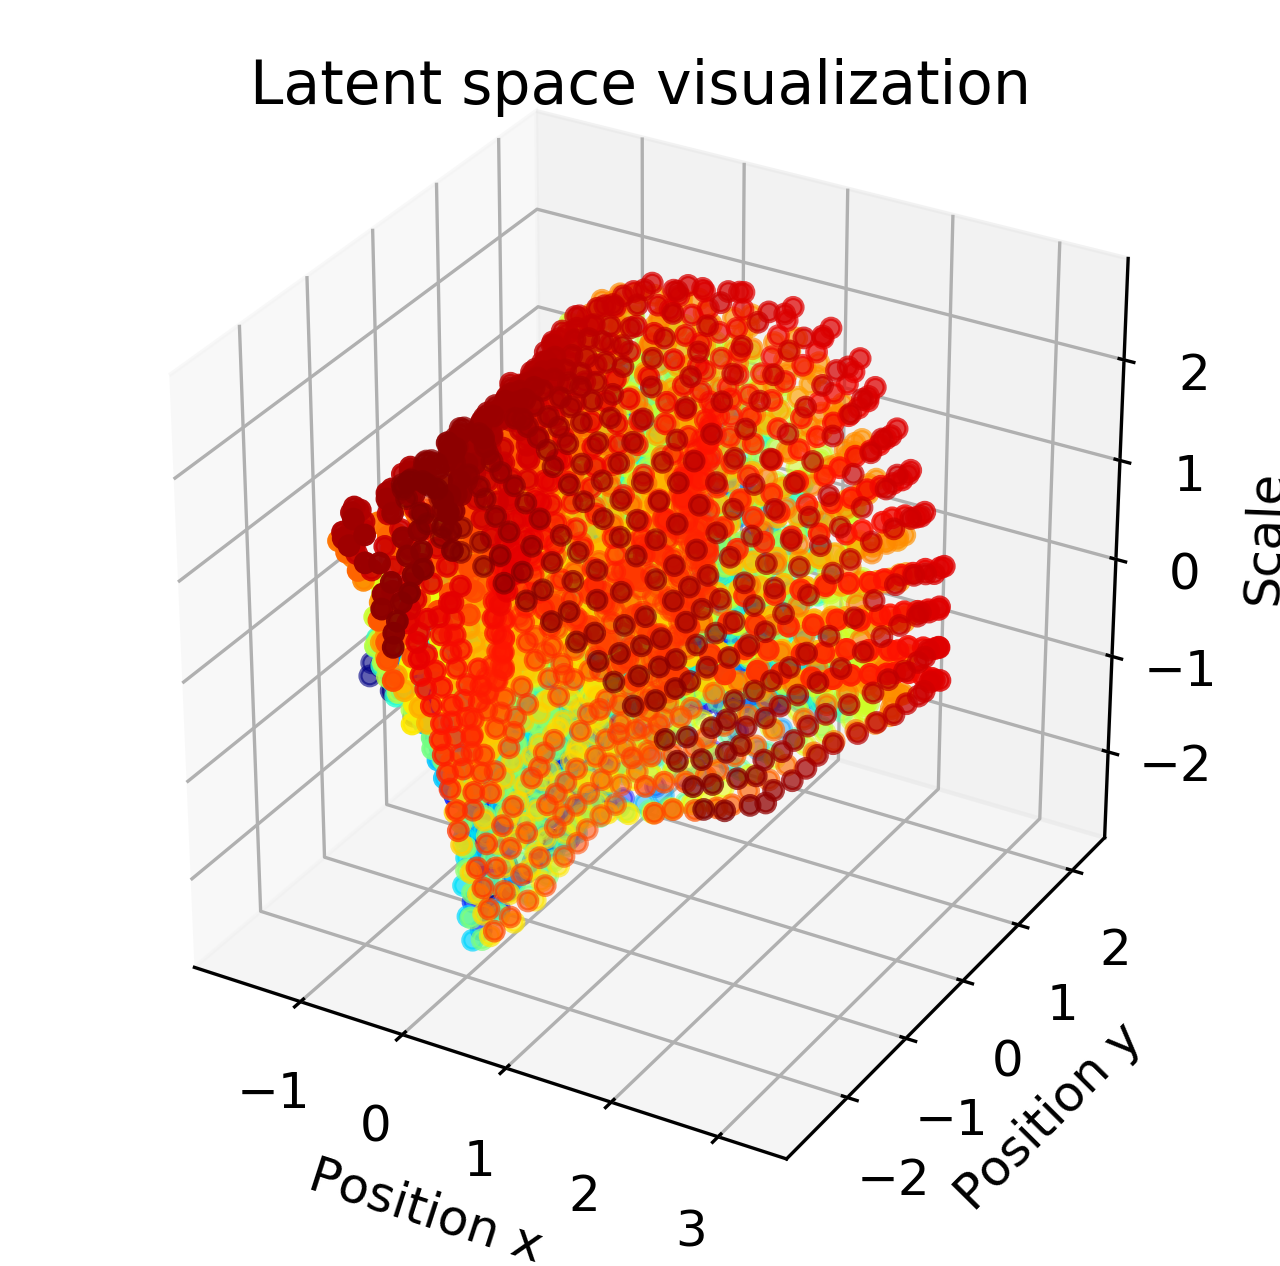

In [36]:
plt.rcParams['figure.dpi'] = 300
plt.rc('font',size=12)
scatter3d(-mu[:,4],mu[:,0],-mu[:,5],cs=np.linspace(0,0.5,32*32*6))

# The representation space of Groupified $\beta$-VAE

In [37]:
latent_matrix = get_latent_matrix()
images = get_images_from_latent(dataset,latent_matrix)
x = torch.from_numpy(images).cuda()
x = x.unsqueeze(1)
x_r,mu,logvar = net_group(x.cuda())
mu = mu.detach().cpu().numpy()

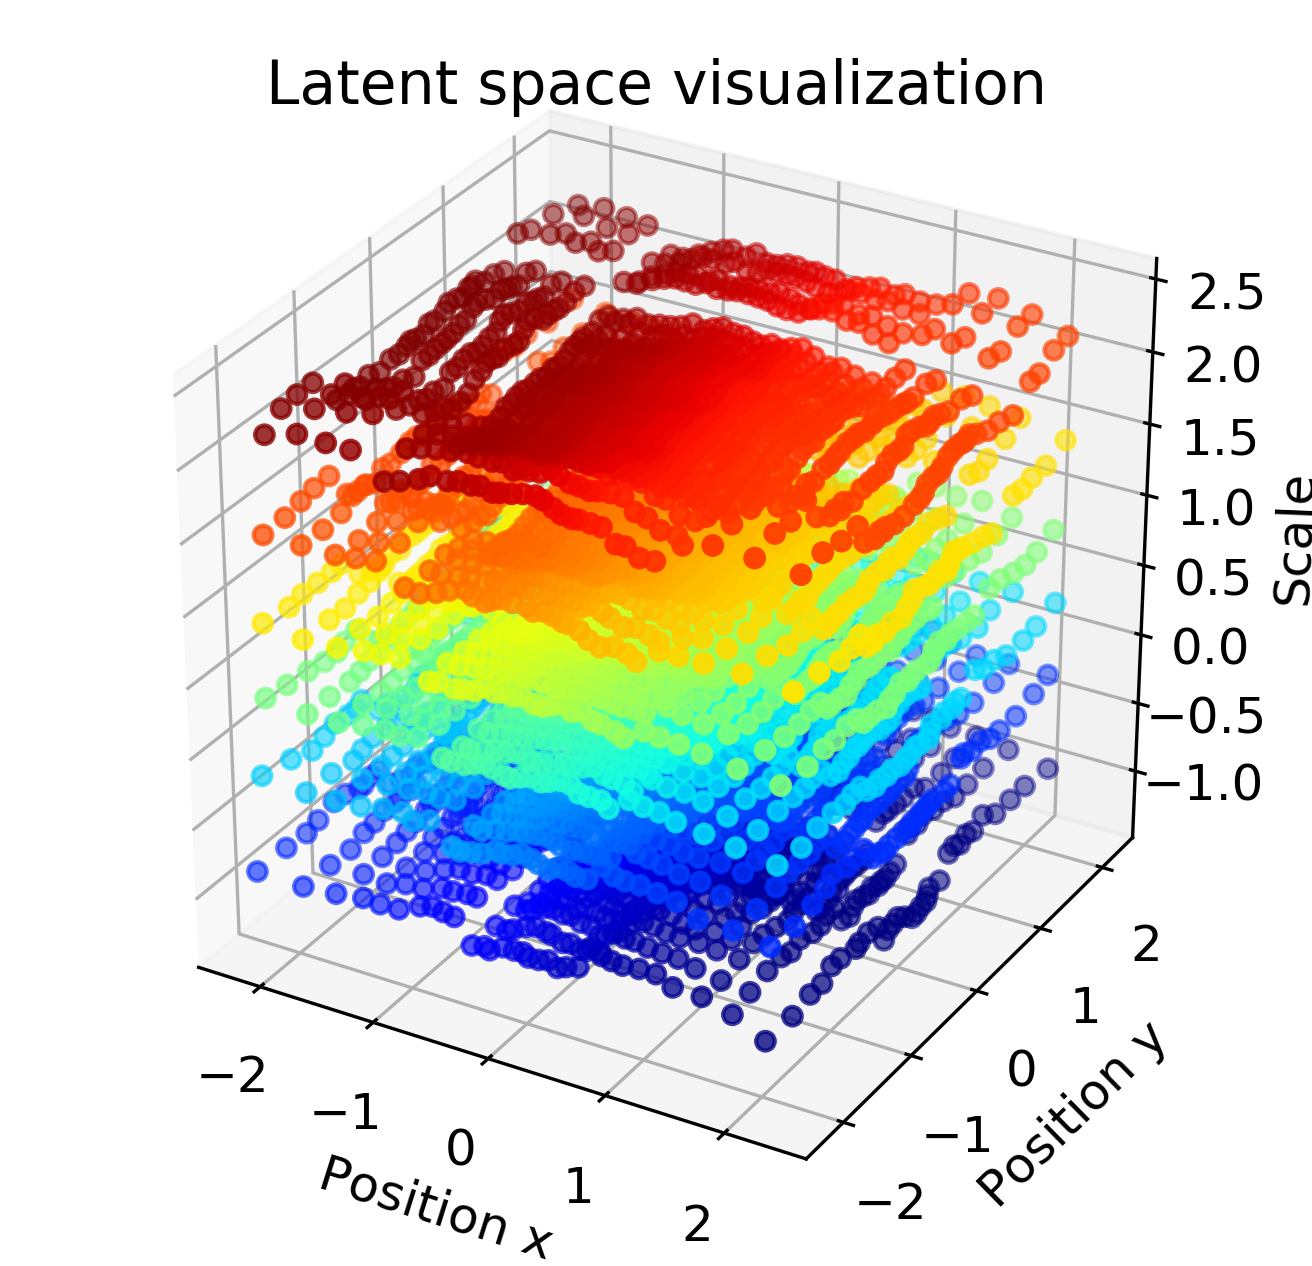

In [38]:
import matplotlib
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.dpi'] = 300
plt.rc('font',size=12)
scatter3d(mu[:,5],mu[:,6],mu[:,9],cs=np.linspace(0,0.5,32*32*6))